In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

retail = pd.read_csv('Online+Retail.csv', sep=',', encoding='ISO-8859-1')
retail['InvoiceDate'] = retail['InvoiceDate'].str.replace('/', '-')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = '%d-%m-%Y %H:%M')
retail.head()

In [100]:
print('Records with description and customer id as null:',len(retail.loc[(~retail.Description.notnull() & ~retail.CustomerID.notnull())]))
print('Records with description as null:',len(retail[~retail.Description.notnull()]))
print('Records with customer id as null:', len(retail[~retail.CustomerID.notnull()]))

Records with description and customer id as null: 1454
Records with description as null: 1454
Records with customer id as null: 135080


In [101]:
OrderWise = retail.dropna()
len(OrderWise)

406829

In [102]:
round(100*(OrderWise.isnull().sum()/len(OrderWise.index)), 2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [103]:
amount = pd.DataFrame(OrderWise.Quantity * OrderWise.UnitPrice, columns=['Amount'])
OrderWise = pd.concat(objs=[OrderWise, amount], axis=1, ignore_index=False)
OrderWise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [104]:
monetary = OrderWise.groupby('CustomerID').Amount.sum()
monetary = monetary.reset_index()  #without this command the monetary object will not have an index column

In [105]:
frequency = OrderWise[['CustomerID', 'InvoiceNo']]
k = pd.DataFrame(frequency.groupby('CustomerID').InvoiceNo.count()).reset_index()
k.columns = ['CustomerID', 'Frequency']

In [106]:
master = monetary.merge(k, on='CustomerID', how='inner')
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [107]:
recency = OrderWise[['CustomerID', 'InvoiceDate']]
maximum = max(recency.InvoiceDate) + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate

df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]

C:\Users\e050078\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
RFM = master.merge(df, on='CustomerID', how='inner')
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


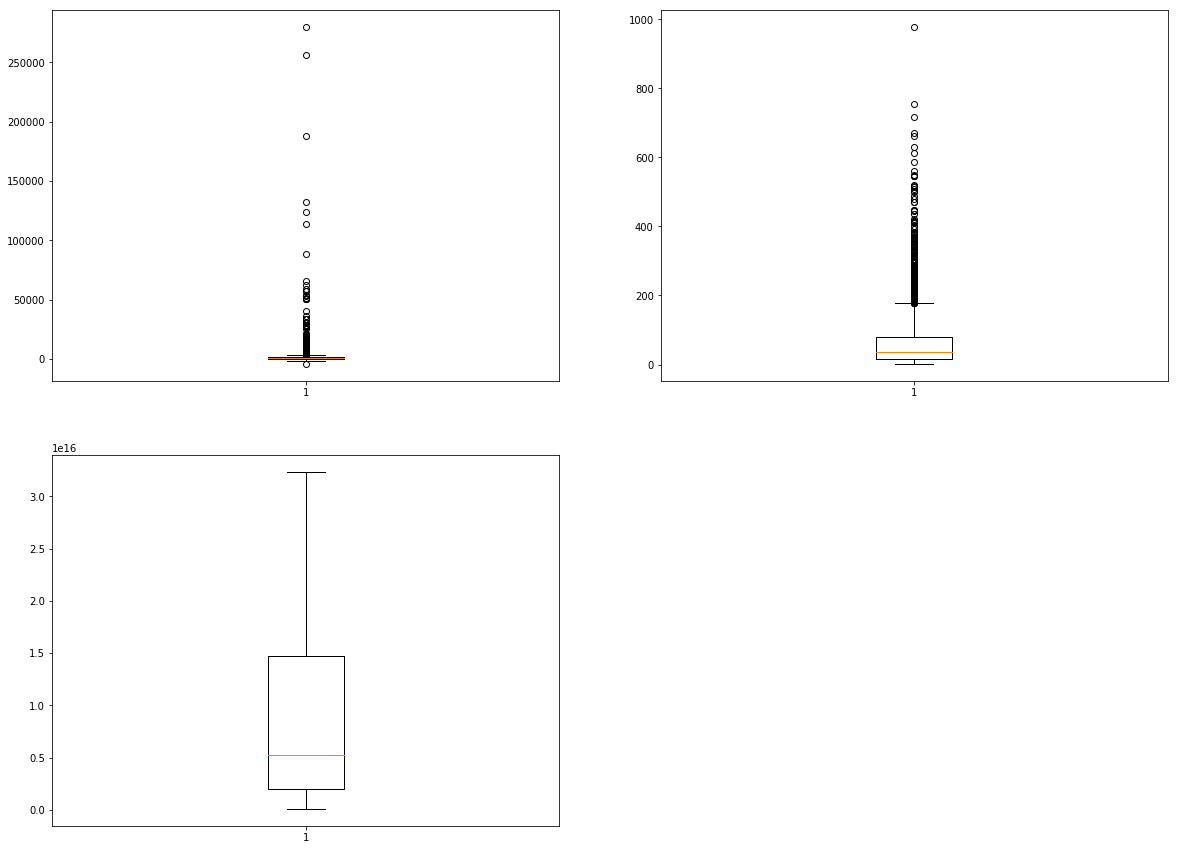

In [109]:
plt.figure(figsize=(20,15))

# outlier treatment for Amount
plt.subplot(221)
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for Frequency
plt.subplot(222)
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

# outlier treatment for Recency
plt.subplot(223)
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

{'whiskers': [<matplotlib.lines.Line2D at 0xc8cad30>,
 'caps': [<matplotlib.lines.Line2D at 0xc8b55c0>,
 'boxes': [<matplotlib.lines.Line2D at 0xc8ca7f0>],
 'medians': [<matplotlib.lines.Line2D at 0xc8b5e10>],
 'fliers': [<matplotlib.lines.Line2D at 0xc8b5ef0>],
 'means': []}

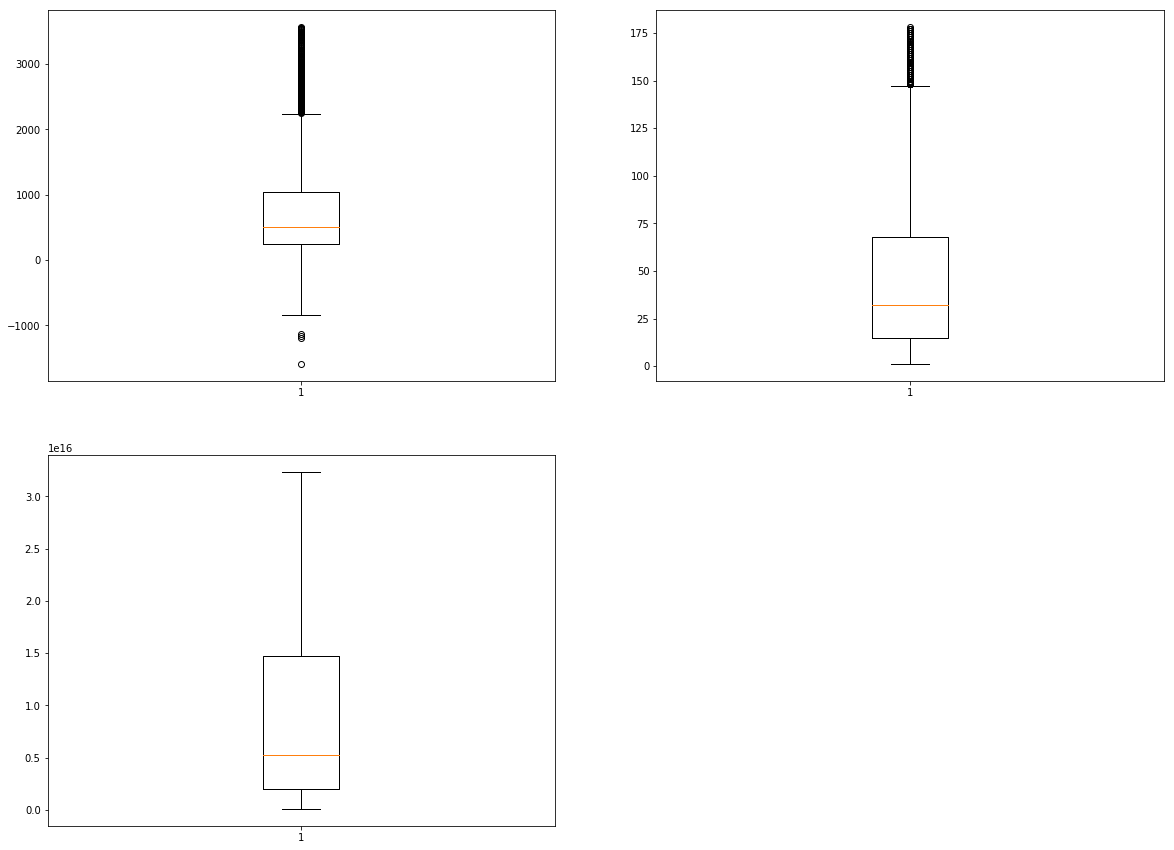

In [111]:
plt.figure(figsize=(20,15))

# outlier treatment for Amount
plt.subplot(221)
plt.boxplot(RFM.Amount)

# outlier treatment for Frequency
plt.subplot(222)
plt.boxplot(RFM.Frequency)

# outlier treatment for Recency
plt.subplot(223)
plt.boxplot(RFM.Recency)

In [113]:
RFM_norml = RFM.drop("CustomerID", axis=1)
RFM_norml.Recency = RFM_norml.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norml)

array([[-1.04161396, -1.07094871,  2.13642223],
       [ 1.38529792, -0.3754979 , -0.28204953],
       [ 1.33170234,  0.63170672, -0.82162889],
       ...,
       [-0.93247827, -0.9510434 ,  0.73929711],
       [-0.80314128, -0.80715703, -0.92761769],
       [ 1.43936613,  0.55976353, -0.59038059]])